<h1> <center> IMAGE CAPTIONING </center> </h1>

<b> References : </b>
1. https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8
2. https://www.tensorflow.org/tutorials/text/image_captioning


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os, glob
import nltk
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
import spacy
import keras
from time import time
from pickle import load, dump

Using TensorFlow backend.
/home/mtnshh/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mtnshh/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mtnshh/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mtnshh/.local/lib/python3.6/site-packages/tensorflow/python

<center><h3> Defining the corpus and vocubalary</h3></center>

In [2]:
# Reading the csv file containing image id and it caption

train = pd.read_csv('./dataset-flick8k/caption-token.csv', delimiter = '\t', header = None)
train.info()

# Reading the file containing the images to be trained 
# train_images --> [] --> contains list of images to be trained

file = open("./dataset-flick8k/Flickr_8k.trainImages.txt", 'r')
train_images = []
cnt = 0
while 1:
    s = file.readline()
    cnt += 1
    if s == "":
        break
    s = s[:len(s)-1]
    train_images.append(s)    

# des --> {} --> image id as key with all its caption
    
cnt = 0
train_caption = {}
des = {}

for i in range(0, len(train)):
    img = train[0][i]
    img = img[:len(img)-2]
    if img in train_images:
        if img not in des:
            des[img] = list()
        
        des[img].append("startseq " + train[1][i] + " endseq")

print(len(des))

def clean_text(text):
#   Allows only alphabets in captions
    text = re.sub('[^a-zA-Z]',' ',text)
#   Converts to lower text
    text = text.lower()
#   Splits string to list
    text = text.split()
#   Lemmatized the word
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text] 
    final = []
    for word in text:
        if word != "-PRON-":
            final.append(word)
    text = ' '.join(final)
    return text
    
image_id = []
corpus = []    

# Corpus --> [] --> contains all the processed captions

for key in des:
    for line in des[key]:
        text = clean_text(line)
        image_id.append(key)
        corpus.append(text)

print(corpus)
print(len(corpus))

# word_cound --> {} --> contains count of each word

word_count = {}

for text in corpus:
#     print(text)
    for w in text.split(' '):
        word_count[w] = word_count.get(w, 0) + 1
    
# vocab --> [] -->  contains all the words that has occured more than 10 times  
#              --> contains 1494 words 
vocab = [w for w in word_count if word_count[w] >= 10]

print(len(vocab))

captions = []

# captions --> [] --> contains the words of caption that are present in vocab

for text in corpus:
    for w in text.split(' '):
        tmp = []
        if w in vocab:
            tmp.append(w)
        tmp =  ' '.join(tmp)
        captions.append(tmp)

# ixtoword --> {} --> provides to index for particle word
# wordtoix --> {} --> provide the word corresponding to particular index
    
ixtoword = {}
wordtoix = {}

ix=1

for w in vocab: 
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40460 entries, 0 to 40459
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       40460 non-null  object
 1   1       40460 non-null  object
dtypes: object(2)
memory usage: 632.3+ KB
6000
['startseq a child in a pink dress is climbing up a set of stair in an entry way endseq', 'startseq a girl going into a wooden building endseq', 'startseq a little girl climbing into a wooden playhouse endseq', 'startseq a little girl climbing the stair to her playhouse endseq', 'startseq a little girl in a pink dress going into a wooden cabin endseq', 'startseq a black dog and a spotted dog are fighting endseq', 'startseq a black dog and a tri colored dog playing with each other on the road endseq', 'startseq a black dog and a white dog with brown spot are staring at each other in the street endseq', 'startseq two dog of different breed looking at each other on the road endseq', 'startseq tw

<h3><center>Finding vectors for each Image using pretrained module Inception v3

In [ ]:
# Load the inception v3 model
model = keras.applications.InceptionV3(weights='imagenet')
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = keras.models.Model(model.input, model.layers[-2].output)

def preprocess(image_path):
     # Convert all the images to size 299x299 as expected by the inception v3 model
    img = keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    # Convert image to numpy array of 3-dimensions
    x = keras.preprocessing.image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = keras.applications.inception_v3.preprocess_input(x)
    return x

# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

# Encoding all the Train Images
encoding_train = {}
for img_path in glob.glob("./train/*"):
    img = img_path[8:]
    encoding_train[img] = encode(img_path)

# Saving encoding_train in file using pickle
with open("./encoded_train_images.pkl", "wb") as encoded_pickle:
    dump(encoding_train, encoded_pickle)

# Encoding all the Test Images
encoding_test = {}
for img_path in glob.glob("./dataset-flick8k/*/*"):
    img = img_path[25:]
    if img not in train_images:
        encoding_test[img] = encode(img_path)

# Saving encoding_test in file using pickle
with open("./encoded_test_images.pkl", "wb") as encoded_pickle:
    dump(encoding_test, encoded_pickle)

<h3><center>Loading Word2Vec model / Glove Vectors

In [ ]:
# Load Glove vectors
glove_dir = '.'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 200
vocab_size = len(intoword) + 1

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoin.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

In [3]:
# Finding max length of caption

max_length = 0

for text in corpus:
    max_length = max(max_length, len(text.split(' ')))

print(max_length)

38


<h3><center>Defining the model

In [ ]:
# This is something I completely copied from blog, without thinking much about parameters.

inputs1 = keras.Input(shape=(2048,))
fe1 = keras.layers.Dropout(0.5)(inputs1)
fe2 = keras.layers.Dense(256, activation='relu')(fe1)
inputs2 = keras.Input(shape=(max_length,))
se1 = keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = keras.layers.Dropout(0.5)(se1)
se3 = keras.layers.LSTM(256)(se2)
decoder1 = keras.layers.add([fe2, se3])
decoder2 = keras.layers.Dense(256, activation='relu')(decoder1)
outputs = keras.layers.Dense(vocab_size, activation='softmax')(decoder2)
model = keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)

model.summary()

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 10
number_pics_per_bath = 3
steps = len(des)//number_pics_per_bath
print(steps)

<h3><center>Data Generator

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list(n)
                n=0

<h3><center>Training</h3></center>

<b> Fun Facts : </b>
    
1. It took around 4 hours to train this model.
2. I tried to use my Graphics Card of 2GB to reduce time, but unfortunately I have AMD Radeon Gaphics Card, and tensorflow only supports Nvidia Graphics Card and Processor.
3. I installed AMD Graphics driver in my Ubuntu, by installing amdpro (following a solution from their official site) which resulted in changing Ubuntu settings, fortunately I uninstalled it, and everything started working properly :)
4. I also followed couple of other solutions to use AMD along with tensorflow, but none of them worked.

<b>Conclusion</b> : I am still not able to used AMD Graphics Card with Tensorflow

In [ ]:
for i in range(epochs):
    generator = data_generator(des, train_features, wordtoin, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model_json = model.to_json()
    file_name = "model_"+str(i)+".json"
    path = "./model_weights/" + file_name
    with open(file_name, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(path)
    print("Saved model to disk")
    
for i in range(epochs):
    generator = data_generator(des, train_features, wordtoin, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model_json = model.to_json()
    file_name = "model_"+str(i)+".json"
    path = "./model_weights/" + file_name
    with open(file_name, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(path)
    print("Saved model to disk")
    
from keras import optimizers
model.optimizer.learning_rate=0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(des)//number_pics_per_bath

for i in range(epochs):
    generator = data_generator(des, train_features, wordtoin, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    
model_json = model.to_json()
file_name = "model_30"+".json"
path = "./model_weights/" + file_name
with open(file_name, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(path)
print("Saved model to disk")

<h3><center>Testing the model

In [4]:
# Loading the model from json file

json_file = open('model_30.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("./model_weights/model_30.json")
print("Loaded model from disk")

model.compile(loss='categorical_crossentropy', optimizer='adam')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Loaded model from disk


In [5]:
# Greedily finds the next word
# From startseq uptill endseq is not found (or max length of caption is reached)

def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [8]:
# Loading Image vector for test Images

with open("./encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

1295698260_e10c53c137.jpg


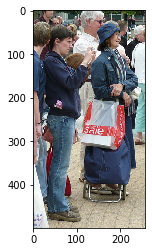

Greedy: man in a black shirt is walking down a street with a woman in a white shirt
-------------------------------------
3247500085_c4f641aa84.jpg


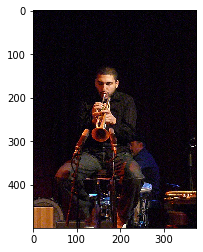

Greedy: man is playing a guitar
-------------------------------------
2709359730_13bca100af.jpg


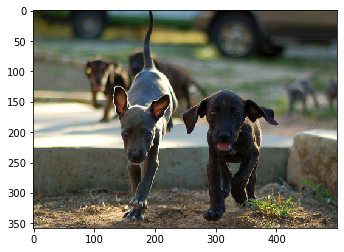

Greedy: brown dog is running through the grass
-------------------------------------
1501985304_8c50093004.jpg


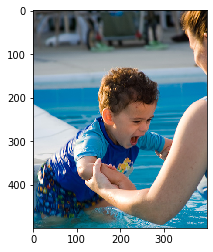

Greedy: boy in a green shirt is jumping into a swimming pool
-------------------------------------
2577972703_a22c5f2a87.jpg


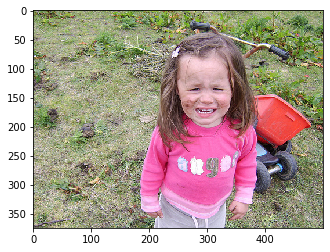

Greedy: little boy is sitting on a shovel with his head around a pull
-------------------------------------
2698666984_13e17236ae.jpg


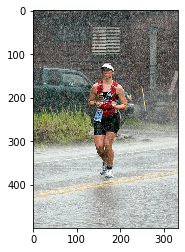

Greedy: man in a wetsuit is walking on a sidewalk with a dog in the background
-------------------------------------
2772084628_c0ae29d87a.jpg


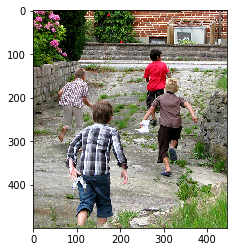

Greedy: man and a woman are walking down a road away from a pond
-------------------------------------
1032122270_ea6f0beedb.jpg


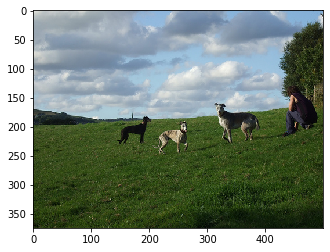

Greedy: white dog is running through a field
-------------------------------------
2490687446_9d46fdf5a9.jpg


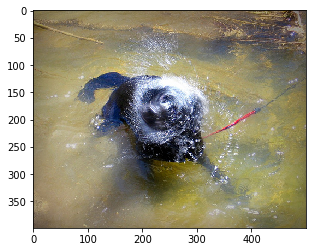

Greedy: black dog is jumping into the water
-------------------------------------
3393152604_27bd1037f2.jpg


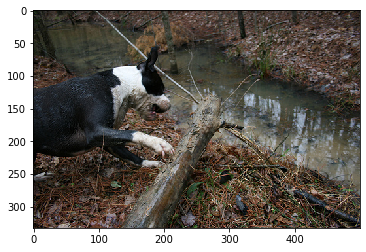

Greedy: black dog is running through a field
-------------------------------------


In [12]:
# Finds caption for Each given Image

for i in range(0,10):
    pic = list(encoding_test.keys())[(last*23)%len(encoding_test)]
    last = (last*23)%len(encoding_test)
    image = encoding_test[pic].reshape((1,2048))
    print(pic)
    x=plt.imread("./dataset-flick8k/Images/" + pic)
    plt.imshow(x)
    plt.show()
    print("Greedy:",greedySearch(image))
    print("-------------------------------------")


<b> Note : </b>
1. I have trained the model in another notebook.
2. These notebook is just for testing the caption of images.

<h3><center> THE END